### Importing Necessary Libraries

In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2S
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [4]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [5]:
roi_info.shape

(16000, 100, 6)

In [6]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

We will be using the image data above and the ROI extraction data as explained [here](RoI-Extraction.ipynb).

In [7]:
BATCH_SIZE = 50
INPUT_SHAPE = (800, 600)

Now due to the quite varying nature of the ROI shapes, the following pre-processing steps on each ROI converts them to same shape as that of the original document images by resizing and padding with the maximum color in the ROI which is mostly white and sometimes greyish, etc.

In [8]:
def resize_and_pad_with_doc_max_col(img, f_target_height=INPUT_SHAPE[0], f_target_width=INPUT_SHAPE[1]):
    f_width = img.shape[1]
    f_height = img.shape[0]
    ratio = np.max([f_width / f_target_width, f_height / f_target_height])
    resized_height_float = f_height / ratio
    resized_width_float = f_width / ratio
    resized_height = tf.cast(
        np.floor(resized_height_float), dtype=tf.int32)
    resized_width = tf.cast(
        np.floor(resized_width_float), dtype=tf.int32)

    padding_height = (f_target_height - resized_height_float) / 2
    padding_width = (f_target_width - resized_width_float) / 2
    f_padding_height = np.floor(padding_height)
    f_padding_width = np.floor(padding_width)
    p_height = np.max([0, tf.cast(f_padding_height, dtype=tf.int32)])
    p_width = np.max([0, tf.cast(f_padding_width, dtype=tf.int32)])

    resized_padded_image = tf.image.resize_with_pad(img, f_target_height, f_target_width).numpy()
    white_color = np.max(resized_padded_image)
    resized_padded_image[:p_height, :] = white_color
    resized_padded_image[(f_target_height-p_height-1):, :] = white_color
    resized_padded_image[:, :p_width] = white_color
    resized_padded_image[:, (f_target_width-p_width-1):] = white_color
    return resized_padded_image

The data generator as created below does the following things:
- It uses the RoI extraction information and the image to extract the portions of the document image and returns a list of these snippet regions.

In [9]:
class ROIGenerator:
    def __init__(self, df, df_roi, X_col, roi_pad=5):
        self.paths = list(df[X_col])
        self.roi_info = df_roi
        self.num_images = df_roi.shape[0]
        self.roi_pad = roi_pad
        self.idx = 0
        
    def generate(self):
        while True:
            if self.idx >= self.num_images:
                self.idx = 0
            image_data = img_to_array(load_img(self.paths[self.idx]))
            roi_data = self.roi_info[self.idx]
            self.idx += 1
            yield [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)]) if pad_mask == 1 else [[]] for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data]

In [10]:
test_gen = ROIGenerator(
    df=labels,
    df_roi=roi_info,
    X_col='images'
)

Below is the generated ROI extractions per image depicted.

Metal device set to: Apple M1 Max


2022-09-26 05:42:35.211421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 05:42:35.211521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


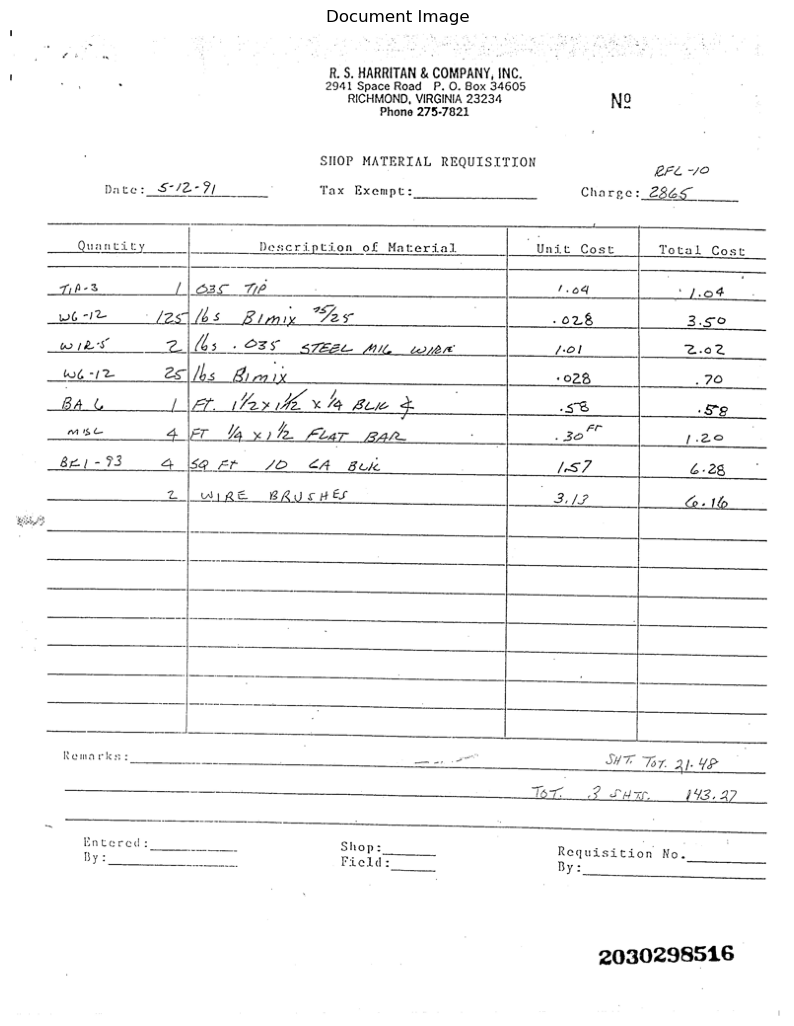

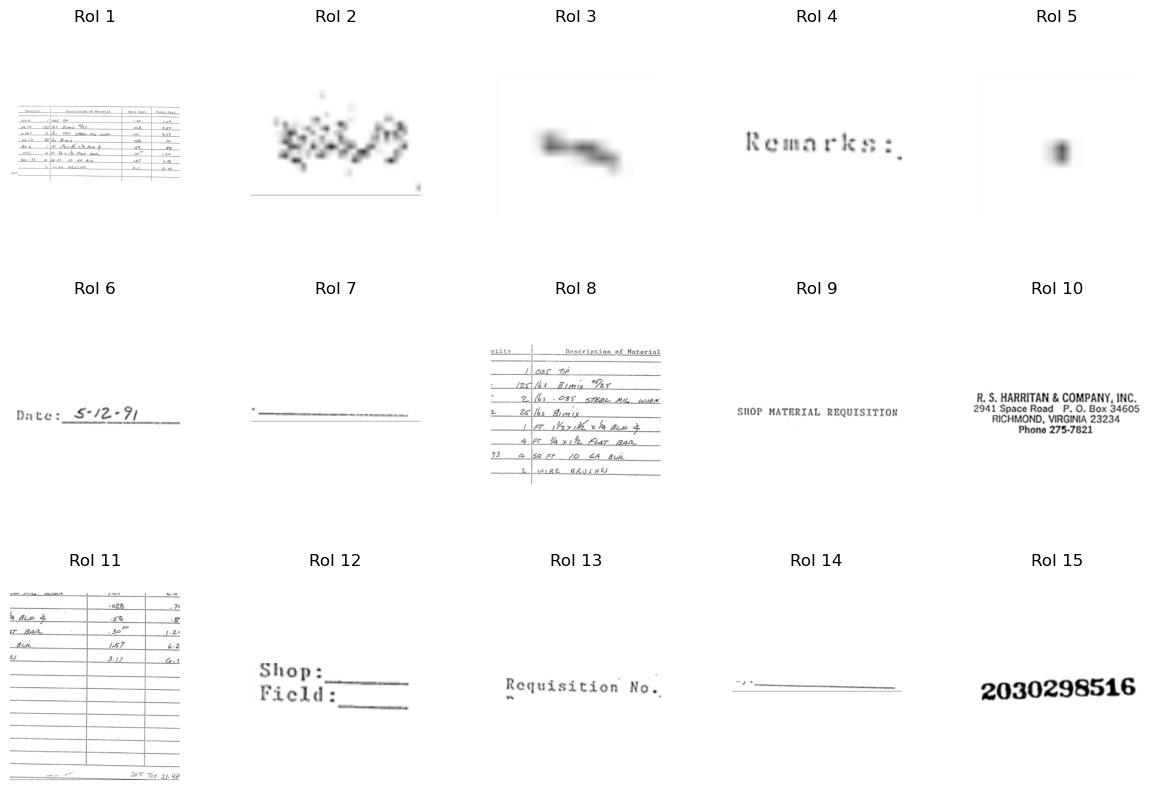

In [11]:
plt.figure(figsize=(10,20))
plt.imshow(tf.cast(img_to_array(load_img('./Data/train/train/0.tif')), dtype=tf.uint8))
plt.axis('off')
plt.title("Document Image")

imgs = next(test_gen.generate())
fig, ax = plt.subplots(3, 5, figsize=(15,10))
k = 0
for i in range(3):
    for j in range(5):
        if len(imgs[k]) != 0:
            ax[i,j].imshow(tf.cast(imgs[k], dtype=tf.uint8))
            ax[i,j].axis('off')
            ax[i,j].set_title(f'RoI {k+1}')
        k += 1

Now, after we have seen how each document image is processed which is an extension to the [4 Piece Add On Model's](EfficientNet-4Piece-Model.ipynb) pre-processing which worked with only 4 pieces.

In [12]:
class ImageDataGenerator:
    def __init__(self, df, X_col, roi_info, y_col, batch_size, roi_pad=5, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.roi_info = roi_info # Contains valid information for the pre-processing of each image
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.roi_pad = roi_pad # Padding on 4 sides for each ROI
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
        
    def __get_input(self, path):
        image_data = img_to_array(load_img(path))
        idx = int(path.split('/')[-1].split('.')[0])
        # some other pre-processing / data-augmentation goes here
        roi_data = self.roi_info[idx]
        return [resize_and_pad_with_doc_max_col(image_data[max(0, int(y_top)-self.roi_pad):min(image_data.shape[0], int(y_bottom)+self.roi_pad), max(0, int(x_top)-self.roi_pad):min(image_data.shape[1], int(x_bottom)+self.roi_pad)]) for x_top, y_top, x_bottom, y_bottom, roi_type, pad_mask in roi_data if pad_mask == 1]

    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch = [np.array(self.__get_input(path)) for path in batch_paths]
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [13]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

In [14]:
# batch = train_generator[0]
# print('*** Batch Overview ***')
# print('Batch Size:', len(batch[0]))
# for i in range(BATCH_SIZE):
#     print(f'Number of ROIs for the {i+1}th input image:', batch[0][i].shape[0])
# print('ROI Dimensions:', batch[0][0].shape[1:])
# print('Output Label Tensor Shape:', batch[1].shape)
# del batch

Because of too many images, the batch visualization is not provided but it is similar to that of above shown for one document which is equivalent to batch size of 1.

## Model Building

After building a couple of CNN models consdering only the entire document image [EfficientNet Only Model](EfficientNet-Only-Model.ipynb) and [4 Piece Add On Model](EfficientNet-4Piece-Model.ipynb). It is now time to build much more better models considering other structures we will start by incorporating the ROI visual features and then later much more.

We will use the following pre-trained model to learn features for these ROIs.

- EfficientNetV2L

The EfficientNetV2L is a large model and since, we are not pre-training the entire model, we will just fine-tune it with few extra layers. So, to fasten training we precompute the output of the EfficientNetV2L model and use this for training the added Dense Layers for Fine-Tuning.

In [15]:
model_effnet = EfficientNetV2L(include_top=False, weights='imagenet')
model_effnet.trainable = False

In [16]:
inp = Input(shape=(*INPUT_SHAPE, 3))
out = model_effnet(inp)
output = GlobalAvgPool2D()(out)
model = tf.keras.Model(inp, output, name='EfficientNet-kPiece')

In [17]:
model.summary()

Model: "EfficientNet-kPiece"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 800, 600, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 117,746,848
Trainable params: 0
Non-trainable params: 117,746,848
_________________________________________________________________


In [18]:
train_generator_precompute = ImageDataGenerator(
    df=labels,
    X_col='images',
    roi_info=roi_info,
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

checkpnt_each = 100
assert checkpnt_each % BATCH_SIZE == 0
checkpnt_i = checkpnt_each // BATCH_SIZE
precompute_output = list()

To avoid memory issues the vector representation of the ROIs of one document is followed immediately by the vectors for the ROIs of the next document. So, when using we will have to keep that in mind.

In [ ]:
for i in range(16000//BATCH_SIZE):
    print(f'{i+1}th Batch')
    batch = train_generator_precompute[i]
    batch = tf.concat(batch[0], axis=0)
    precompute_output.append(model.predict(batch))
    if (i+1) % checkpnt_i == 0:
        precompute_output = tf.concat(precompute_output, axis=0).numpy()
        np.save(f'./Data/EffNet-kP-train-precompute/train_data_precomp-{(i+1)//checkpnt_i}.npy', precompute_output)
        precompute_output = list()

1th Batch


2022-09-26 05:42:54.592516: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 05:42:56.537050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 69s 2s/step
2th Batch
26/26 [==============================] - 88s 3s/step
3th Batch
23/23 [==============================] - 133s 6s/step
4th Batch
26/26 [==============================] - 147s 6s/step
5th Batch
23/23 [==============================] - 129s 6s/step
6th Batch
26/26 [==============================] - 88s 3s/step
7th Batch
26/26 [==============================] - 147s 6s/step
8th Batch
28/28 [==============================] - 159s 6s/step
9th Batch
 2/25 [=>............................] - ETA: 2:14

In [40]:
# fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/EffNet-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
# np.save(f'./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
# fine_tune_data.shape

(16000, 5, 1280)

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per 4 parts of the image and full image ($4+1=5$) which will be used to train the later extra layers of our model.

In [13]:
fine_tune_data = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1280)

In [14]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [15]:
def ftmodel():
    inputs = Input(shape=(5, 1280))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_final')(x)
    outputs = Dense(16, activation='softmax', name='pred')(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')
    return model1

In [16]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1280)]         0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 batch_normalization (BatchN  (None, 6400)             25600     
 ormalization)                                                   
                                                                 
 top_dropout_1 (Dropout)     (None, 6400)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              6554624   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                             

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors.

In [17]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [18]:
# EPOCHS = 2000
# checkpoint_filepaths = ['./Models/EfficientNet-4P/auto-EffNet-FT-model-weight']
# model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor = "loss",
#     mode='min',
#     save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [ ]:
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
# model1.save_weights("./Models/EfficientNet-4P/effnet-4p-model-weights")
model1.load_weights('./Models/EfficientNet-4P/effnet-4p-model-weights')

In [20]:
# def plot_train_loss(history, model_name):  
#     plt.figure(figsize=(8,6))
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['accuracy'])
#     plt.title(model_name+' loss')
#     plt.ylabel('loss')
#     plt.xlabel('epochs')
#     plt.legend(['train', 'accuracy'], loc='upper left')

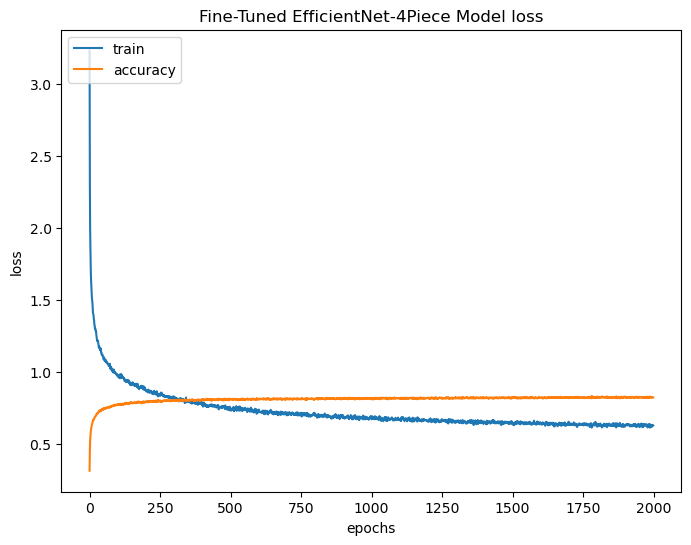

In [21]:
# plot_train_loss(history, 'Fine-Tuned EfficientNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [22]:
train_preds = model1.predict(fine_tune_data)

 64/500 [==>...........................] - ETA: 1s

2022-09-11 19:45:31.721251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 1s 2ms/step


In [23]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [24]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [25]:
np.sum(train_pred_labels == labels['label'])

14789

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [27]:
mis_train_data = labels[train_pred_labels != labels['label']]
mis_train_data

,id,images,label
37,37,./Data/train/train/37.tif,5
49,49,./Data/train/train/49.tif,13
77,77,./Data/train/train/77.tif,14
100,100,./Data/train/train/100.tif,10
101,101,./Data/train/train/101.tif,13
...,...,...,...
15950,15950,./Data/train/train/15950.tif,13
15953,15953,./Data/train/train/15953.tif,7
15955,15955,./Data/train/train/15955.tif,11
15959,15959,./Data/train/train/15959.tif,5


In [94]:
precision, recall, fscore, support = score(labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.916251,0.890504,0.903194,1032
1,0.884534,0.861713,0.872974,969
2,0.988718,0.995868,0.992280,968
3,0.989033,0.998993,0.993988,993
4,0.988506,0.979296,0.983879,966
5,0.844237,0.803360,0.823291,1012
6,0.977842,0.972222,0.975024,1044
7,0.944269,0.930570,0.937370,965
8,0.943750,0.998111,0.970170,1059
9,0.936399,0.957000,0.946588,1000


#### On Validation Data

Generating Predictions for the Validation Set

In [67]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, batch_size, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        img_arr = img_to_array(load_img(path))
        # some other pre-processing / data-augmentation goes here
        img_arr = tf.image.resize(img_arr, self.input_size)
        img_hdr, img_bdl, img_bdr, img_ftr = img_arr[:250], img_arr[250:-250, :300], img_arr[250:-250, -300:], img_arr[-250:]
        return [img_hdr/255.0, img_bdl/255.0, img_bdr/255.0, img_ftr/255.0, img_arr/255.0]
    
    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        X_batch_4 = [self.__get_input(path) for path in batch_paths]
        X_batch = tf.cast([img[0] for img in X_batch_4], dtype=tf.float32), tf.cast([img[1] for img in X_batch_4], dtype=tf.float32), tf.cast([img[2] for img in X_batch_4], dtype=tf.float32), tf.cast([img[3] for img in X_batch_4], dtype=tf.float32), tf.cast([img[4] for img in X_batch_4], dtype=tf.float32)
        return (X_batch, )
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X = self.__get_data(batches)
        return X
    
    def __len__(self):
        return self.n // self.batch_size

In [69]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data

,images
0,./Data/validation/validation/18282.tif
1,./Data/validation/validation/18296.tif
2,./Data/validation/validation/17833.tif
3,./Data/validation/validation/17827.tif
4,./Data/validation/validation/18241.tif
...,...
895,./Data/validation/validation/18502.tif
896,./Data/validation/validation/18264.tif
897,./Data/validation/validation/18258.tif
898,./Data/validation/validation/17802.tif


In [70]:
valid_generator = ImageDataGenerator(
    df=validation_data,
    X_col='images',
    batch_size=30,
    shuffle=False
)

In [82]:
valid_preds = model.predict(valid_generator)
valid_preds = np.transpose(np.concatenate([dat[np.newaxis,:,:] for dat in valid_preds]), (1,0,2))
valid_preds = model1.predict(valid_preds)

29/29 [==============================] - 0s 5ms/step


2022-09-11 20:07:47.669726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [86]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [87]:
submission_data = pd.DataFrame({'id':[name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]})
submission_data['label'] = valid_pred_labels
submission_data.sort_values(by=['id'], inplace=True)
submission_data

,id,label
850,17801,4
898,17802,6
852,17803,4
798,17804,8
750,17805,3
...,...,...
246,18696,7
211,18697,12
760,18698,8
787,18699,8


In [88]:
submission_data.to_csv('./Submissions/submission-5.csv', index=False)